#### start of the Notebook

<b> Importing libraries required for analysis </b>

In [1]:
#imporing data manipulation libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
!pip install folium
import folium
from folium.plugins import HeatMap
from folium import plugins

from folium.plugins import MarkerCluster



#importing statistical libraries to perform machine learning techniques
!pip install statsmodels
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot

!pip install pmdarima
from pmdarima import auto_arima
sns.set()

import geocoder

In [2]:
df_bk_data = pd.read_excel("C://Users//siddh//Downloads//GDA DATA.xlsx")

<b> In the given dataset the coordinates for the bike stations and area were also added for analysis</b>

In [4]:
df_bk_data.head(5)

,Trip ID,Duration,Start Date,Area,Start Station,Start Terminal,Start Latitude,Start Longitude,End Date,End Station,...,End Longitude,Bike #,Subscriber Type,Zip Code,Start_Date_date,DOW,Week,Start Hour,End Hour,Unnamed: 21
0,432946,406,2014-08-31,Mountain View,Mountain View Caltrain Station,28,37.394782,-122.07548,2014-08-31,Castro Street and El Camino Real,...,-122.083839,17,Subscriber,94040,2014-08-31,Sunday,2014-08-25,22,22:38:00,False
1,432945,468,2014-08-31,San Francisco,Beale at Market,56,37.791920,-122.39679,2014-08-31,Market at 4th,...,-122.405914,509,Customer,11231,2014-08-31,Sunday,2014-08-25,22,22:15:00,False
2,432944,534,2014-08-31,San Francisco,Beale at Market,56,37.791920,-122.39679,2014-08-31,Market at 4th,...,-122.405914,342,Customer,11231,2014-08-31,Sunday,2014-08-25,22,22:15:00,False
3,432942,1041,2014-08-31,San Francisco,Embarcadero at Sansome,60,37.805080,-122.40350,2014-08-31,Steuart at Market,...,-122.394756,603,Customer,94521,2014-08-31,Sunday,2014-08-25,21,22:02:00,False
4,432941,1091,2014-08-31,San Francisco,Embarcadero at Sansome,60,37.805080,-122.40350,2014-08-31,Steuart at Market,...,-122.394756,598,Customer,94521,2014-08-31,Sunday,2014-08-25,21,22:02:00,False


<b>Doing a sanity check of data. It contains following number of rows and columns:</b>

In [5]:
df_bikeshare = df_bk_data.copy()
df_bikeshare.shape

(171792, 22)

In [6]:
df_bikeshare.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171792 entries, 0 to 171791
Data columns (total 22 columns):
Trip ID            171792 non-null int64
Duration           171792 non-null int64
Start Date         171792 non-null datetime64[ns]
Area               171792 non-null object
Start Station      171792 non-null object
Start Terminal     171792 non-null int64
Start Latitude     171792 non-null float64
Start Longitude    171792 non-null float64
End Date           171792 non-null datetime64[ns]
End Station        171792 non-null object
End Terminal       171792 non-null int64
End Latitude       171792 non-null float64
End Longitude      171792 non-null float64
Bike #             171792 non-null int64
Subscriber Type    171792 non-null object
Zip Code           171581 non-null object
Start_Date_date    171792 non-null datetime64[ns]
DOW                171792 non-null object
Week               171792 non-null datetime64[ns]
Start Hour         171792 non-null int64
End Hour           

<b>The column names are not in standarized format. Below code makes it uniform as required</b>

In [7]:
df_bikeshare.columns = df_bikeshare.columns.str.strip().str.lower()\
                        .str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

df_bikeshare = df_bikeshare.rename(columns = {'dow':'week_days','start_latitude':'strt_lat', 'start_longitude':'strt_lon',\
                          'start_station':'strt_stat', 'end_station':'end_stat','end_latitude':'end_lat',\
                          'end_longitude':'end_lon', 'subscriber_type':'subsc_typ'})

In [8]:
with pd.option_context('display.max_rows', 0, 'display.max_columns', 0):
    print(df_bikeshare.isnull().sum(axis = 0))

trip_id              0
duration             0
start_date           0
area                 0
strt_stat            0
start_terminal       0
strt_lat             0
strt_lon             0
end_date             0
end_stat             0
end_terminal         0
end_lat              0
end_lon              0
bike_#               0
subsc_typ            0
zip_code           211
start_date_date      0
week_days            0
week                 0
start_hour           0
end_hour             0
unnamed:_21          0
dtype: int64


<b>We see that some columns are related to customer or bike information or duplicate column. These fields do not mean much for the bike ride once its finished and hence, such fields are not relevant for our analysis. We will remove these at later step </b>

In [9]:
#removing the alternate name for station given in round brackets and making the station name uniform

def clean_station_name(df):
    
    df['strt_stat'] = df['strt_stat'].str.split("(", n = 1, expand = True)
    df['end_stat'] = df['end_stat'].str.split("(", n = 1, expand = True) 
    df['strt_stat'] = df.strt_stat.str.strip()
    df['end_station'] = df.end_stat.str.strip()
    return df



def bk_keep(df):
    if not df.empty:
        
        #fetch relevant columns
        
        cols_needed = ['trip_id',\
                       'duration',\
                      'start_date',\
                       'area',\
                      'strt_stat',\
                      'strt_lat',\
                      'strt_lon',\
                      'end_date',\
                      'end_stat',\
                      'end_lat',\
                      'end_lon',\
                      'subsc_typ',\
                      'week_days',\
                      'week',\
                      'start_hour',\
                      'end_hour']
        
        df = df[cols_needed]
        
        #fix station names
        df= clean_station_name(df)
        
        #fix data types
        
        df['start_date'] = pd.to_datetime(df['start_date'], format = '%Y-%m')
        df['end_date'] = pd.to_datetime(df_bikeshare['end_date'], format = '%Y-%m')
        df['area'] = df['area'].str.split("(", n = 1, expand = True) 
        df['subsc_typ'] = df['subsc_typ'].astype('category')
        df['week_days'] = df['week_days'].astype('category')
        return df
    else:
        print("no data present in the bike share dataframe")

In [10]:
df_bikeshare = bk_keep(df_bikeshare)
df_bikeshare.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

(171792, 17)

<b>All relevant Bike Share columns are clean now</b>

<b>Based on number of trips below are the top 10 stations for bike share </b>

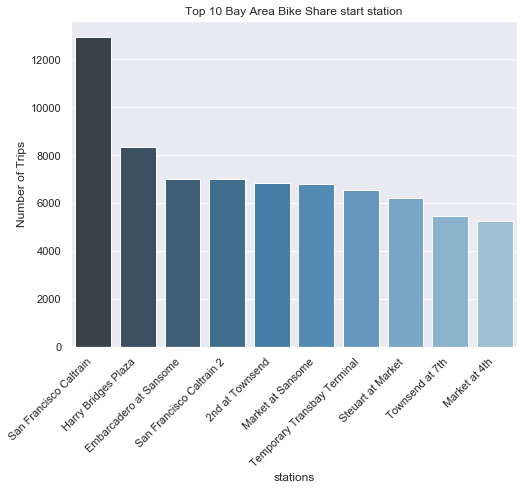

In [11]:
#popular start staion
vc = df_bikeshare['strt_stat'].value_counts().nlargest(10)
df1 = vc.rename_axis('strt_stat').reset_index(name='counts')

plt.figure(figsize=(8, 6))

viz=sns.barplot(data=df1, x= df1['strt_stat'], y=df1['counts'], palette="Blues_d")
viz.set_title('Top 10 Bay Area Bike Share start station')
plt.ylabel('Number of Trips', fontsize=12)
plt.xlabel('stations', fontsize=12)
viz.set_xticklabels(viz.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

<b>Based on the most frequent bike trip occuring below we are taking the top 50.</b>

In [64]:
#frequency of trips between start and end terminals
df_bike_path= df_bikeshare.groupby(['strt_stat','strt_lat','area','strt_lon','end_stat', 'end_lat', 'end_lon'])\
         .size().nlargest(50)

df_bike_path = df_bike_path.rename('trip_num').reset_index()


In [65]:
df_bike_path.head(5)

,strt_stat,strt_lat,area,strt_lon,end_stat,end_lat,end_lon,trip_num
0,Harry Bridges Plaza,37.795343,San Francisco,-122.394141,Embarcadero at Sansome,37.805080,-122.403500,1689
1,Townsend at 7th,37.771924,San Francisco,-122.401651,San Francisco Caltrain,37.777138,-122.395109,1527
2,San Francisco Caltrain 2,37.776790,San Francisco,-122.394822,Townsend at 7th,37.771924,-122.401651,1352
3,Embarcadero at Sansome,37.805080,San Francisco,-122.403500,Steuart at Market,37.794610,-122.394756,1128
4,2nd at Townsend,37.780620,San Francisco,-122.390530,Harry Bridges Plaza,37.795343,-122.394141,1109


Text(0.5, 1.0, 'Density and distribution of trips for each area')

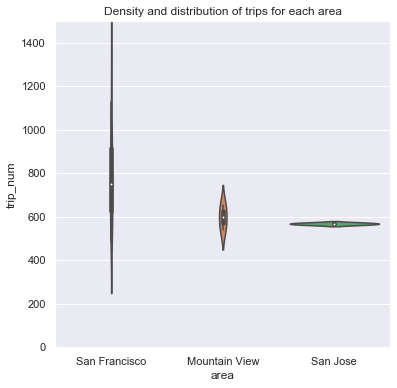

In [69]:
plt.figure(figsize=(6, 6))
plt.ylim(0, 1500)
viz=sns.violinplot(data=df_bike_path, x='area', y='trip_num')
viz.set_title('Density and distribution of trips for each area')

<b> From the map we find the San Francisco area and especially the bike stations near Caltrains and I-80 are the most frequent routes by customer.</b>

In [17]:
locations = df_bike_path[['strt_lat', 'strt_lon']]

locationlist = locations.values.tolist()
len(locationlist)
locationlist[7]

map = folium.Map(location=[ 37.773972, -122.431297], zoom_start=9)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df_bike_path['strt_stat'][point]).add_to(map)
map


<b> We are trying to analyze the profitability of investing in more bikes for the bike stations which are among the most frequented routes. </b>
    
 The analysis is done on the basis of 
 
 Metric: 
         1. daily trip rate (dly_trip_rt):            sum total of trips for a given date 
         2. daily station trip rate (dly_stat_rt):    sum of total trips for a station on a given date
         3. daily station trip rate (dly_stat_trip_rt):   daily trip rate / daily station trip rate

In [20]:
df_dly_trip= df_bikeshare.groupby(['start_date']).size()

df_dly_trip = df_dly_trip.rename('dly_trip_rt').reset_index()

In [21]:
df_dly_trip.head(2)

,start_date,dly_trip_rt
0,2014-03-01,318
1,2014-03-02,208


In [22]:
df_stat_trip = df_bikeshare.groupby(['start_date','strt_stat','area','week','week_days']).size()
df_stat_trip = df_stat_trip.rename('dly_stat_rt').reset_index()

In [23]:
df_stat_trip.head(2)

,start_date,strt_stat,area,week,week_days,dly_stat_rt
0,2014-03-01,2nd at Folsom,San Francisco,2014-02-24,Saturday,6
1,2014-03-01,2nd at South Park,San Francisco,2014-02-24,Saturday,6


In [24]:
df_dly_trip.start_date = df_dly_trip.start_date.astype(str)
df_stat_trip.start_date = df_stat_trip.start_date.astype(str)
df_bk_rt = df_stat_trip.merge(df_dly_trip, on='start_date', how='left')

In [25]:
df_bk_rt.isnull().sum()

start_date     0
strt_stat      0
area           0
week           0
week_days      0
dly_stat_rt    0
dly_trip_rt    0
dtype: int64

In [26]:
df_bk_rt['dly_stat_trip_rt'] = df_bk_rt['dly_stat_rt'].div(df_bk_rt['dly_trip_rt'], axis=0)
df_bk_rt.loc[:,'dly_stat_trip_rt'] *= 100
df_bk_rt.head(5)


,start_date,strt_stat,area,week,week_days,dly_stat_rt,dly_trip_rt,dly_stat_trip_rt
0,2014-03-01,2nd at Folsom,San Francisco,2014-02-24,Saturday,6,318,1.886792
1,2014-03-01,2nd at South Park,San Francisco,2014-02-24,Saturday,6,318,1.886792
2,2014-03-01,2nd at Townsend,San Francisco,2014-02-24,Saturday,4,318,1.257862
3,2014-03-01,5th at Howard,San Francisco,2014-02-24,Saturday,10,318,3.144654
4,2014-03-01,Arena Green / SAP Center,San Jose,2014-02-24,Saturday,2,318,0.628931


In [27]:
df_bk_rt['start_date'] = df_bk_rt['start_date'].astype('datetime64[ns]') 
df_bk_rt.dtypes

start_date          datetime64[ns]
strt_stat                   object
area                        object
week                datetime64[ns]
week_days                 category
dly_stat_rt                  int64
dly_trip_rt                  int64
dly_stat_trip_rt           float64
dtype: object

In [28]:
df_bk_cleaned = df_bk_rt.copy()
df_bk_cleaned = df_bikeshare.groupby(['start_date','strt_stat']).agg({'duration': 'sum'})
#df1=pd.pivot_table(df_bikeshare, index=['start_date','strt_stat'],values=['duration'],aggfunc=np.sum).rename('tot_trip_dur')
#df1['tot_trip_dur'] = df_bikeshare.groupby(['start_date','strt_stat'])['duration'].transform(lambda x: x.sum())
df_bk_cleaned.head(5)

duration
start_date strt_stat                         
2014-03-01 2nd at Folsom                 2768
           2nd at South Park             5136
           2nd at Townsend               2903
           5th at Howard                 9638
           Arena Green / SAP Center       591

<b>The main purpose of analysis is to perform a profitability analysis of stations 
the following steps enables us to use the bike shar data to forecast 2014 September trip rate</b>

<b>we use a single station data to understand the forecasting process and later apply same technique to the entire data</b>

In [29]:
stn = 'San Francisco Caltrain 2'
samplestat = df_bk_rt[df_bk_rt['strt_stat']==stn]


In [30]:
samplestat.head()

,start_date,strt_stat,area,week,week_days,dly_stat_rt,dly_trip_rt,dly_stat_trip_rt
38,2014-03-01,San Francisco Caltrain 2,San Francisco,2014-02-24,Saturday,8,318,2.515723
87,2014-03-02,San Francisco Caltrain 2,San Francisco,2014-02-24,Sunday,4,208,1.923077
146,2014-03-03,San Francisco Caltrain 2,San Francisco,2014-03-03,Monday,36,746,4.825737
207,2014-03-04,San Francisco Caltrain 2,San Francisco,2014-03-03,Tuesday,40,944,4.237288
268,2014-03-05,San Francisco Caltrain 2,San Francisco,2014-03-03,Wednesday,47,979,4.800817


In [31]:
samplestat.isnull().sum()

start_date          0
strt_stat           0
area                0
week                0
week_days           0
dly_stat_rt         0
dly_trip_rt         0
dly_stat_trip_rt    0
dtype: int64

In [32]:
samplestat = samplestat.set_index('start_date').asfreq('d')

<b>To perform a time series forecast, we need the date column as index of the entire series</b>

In [33]:
samplestat.head()


,strt_stat,area,week,week_days,dly_stat_rt,dly_trip_rt,dly_stat_trip_rt
start_date,,,,,,,
2014-03-01,San Francisco Caltrain 2,San Francisco,2014-02-24,Saturday,8,318,2.515723
2014-03-02,San Francisco Caltrain 2,San Francisco,2014-02-24,Sunday,4,208,1.923077
2014-03-03,San Francisco Caltrain 2,San Francisco,2014-03-03,Monday,36,746,4.825737
2014-03-04,San Francisco Caltrain 2,San Francisco,2014-03-03,Tuesday,40,944,4.237288
2014-03-05,San Francisco Caltrain 2,San Francisco,2014-03-03,Wednesday,47,979,4.800817


In [34]:
samplestat.tail()

,strt_stat,area,week,week_days,dly_stat_rt,dly_trip_rt,dly_stat_trip_rt
start_date,,,,,,,
2014-08-27,San Francisco Caltrain 2,San Francisco,2014-08-25,Wednesday,60,1479,4.056795
2014-08-28,San Francisco Caltrain 2,San Francisco,2014-08-25,Thursday,69,1340,5.149254
2014-08-29,San Francisco Caltrain 2,San Francisco,2014-08-25,Friday,66,1252,5.271565
2014-08-30,San Francisco Caltrain 2,San Francisco,2014-08-25,Saturday,9,481,1.871102
2014-08-31,San Francisco Caltrain 2,San Francisco,2014-08-25,Sunday,6,473,1.268499


<b>we plot the trend of sample station to understand how it is behaving</b>

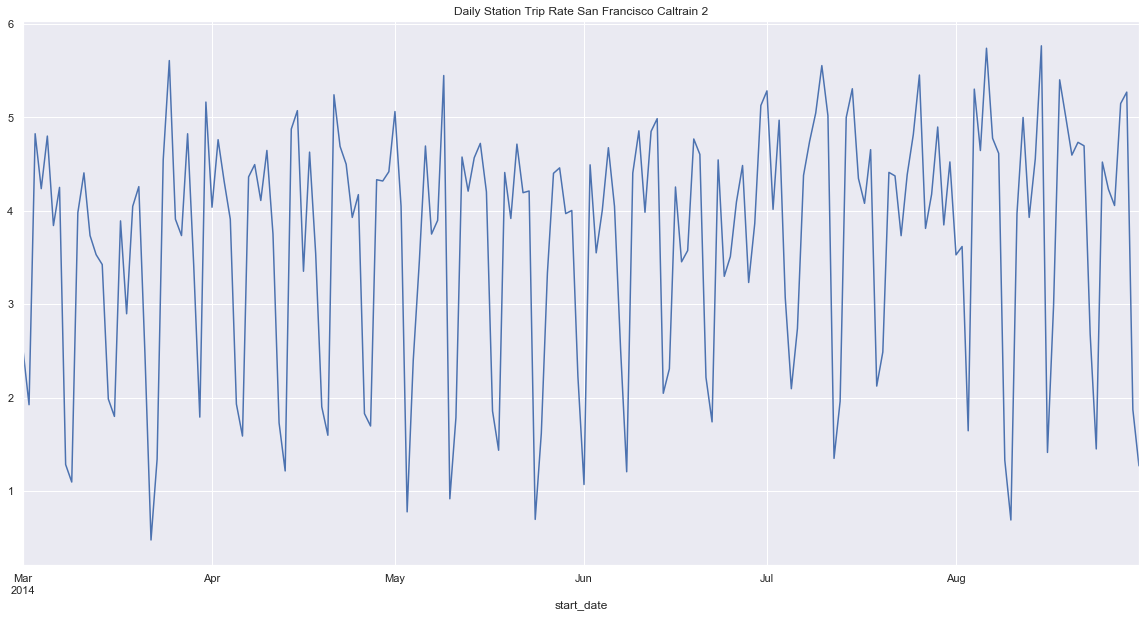

In [35]:
samplestat.dly_stat_trip_rt.plot(figsize=(20,10))
plt.title('Daily Station Trip Rate {}'.format(stn))
plt.show()

<b>Generates a probability plot of sample station against the quantiles of a specified theoretical normal distribution.
We see that our data is not normally distributed</b>

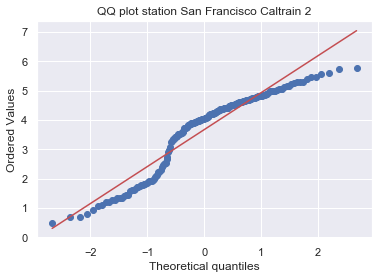

In [36]:
import scipy.stats as ss
import pylab
plt.figsize=(40,20)
ss.probplot(samplestat.dly_stat_trip_rt,plot=pylab)
pylab.title('QQ plot station {}'.format(stn))
pylab.show()

<b>We split our sample zip code data into training / test data to first fit our forecast model and then test it on unseen data</b>

In [38]:
samplesize=int(len(samplestat)*0.8)
samplestat_train=samplestat.iloc[:samplesize]
samplestat_test=samplestat.iloc[samplesize:]

In [39]:
len(samplestat_test)

37

In [40]:
samplestat_train.head()

,strt_stat,area,week,week_days,dly_stat_rt,dly_trip_rt,dly_stat_trip_rt
start_date,,,,,,,
2014-03-01,San Francisco Caltrain 2,San Francisco,2014-02-24,Saturday,8,318,2.515723
2014-03-02,San Francisco Caltrain 2,San Francisco,2014-02-24,Sunday,4,208,1.923077
2014-03-03,San Francisco Caltrain 2,San Francisco,2014-03-03,Monday,36,746,4.825737
2014-03-04,San Francisco Caltrain 2,San Francisco,2014-03-03,Tuesday,40,944,4.237288
2014-03-05,San Francisco Caltrain 2,San Francisco,2014-03-03,Wednesday,47,979,4.800817


In [41]:
samplestat_train.tail()

,strt_stat,area,week,week_days,dly_stat_rt,dly_trip_rt,dly_stat_trip_rt
start_date,,,,,,,
2014-07-21,San Francisco Caltrain 2,San Francisco,2014-07-21,Monday,54,1224,4.411765
2014-07-22,San Francisco Caltrain 2,San Francisco,2014-07-21,Tuesday,58,1326,4.374057
2014-07-23,San Francisco Caltrain 2,San Francisco,2014-07-21,Wednesday,51,1366,3.733529
2014-07-24,San Francisco Caltrain 2,San Francisco,2014-07-21,Thursday,57,1299,4.387991
2014-07-25,San Francisco Caltrain 2,San Francisco,2014-07-21,Friday,58,1204,4.817276


In [42]:
samplestat_test.head()

,strt_stat,area,week,week_days,dly_stat_rt,dly_trip_rt,dly_stat_trip_rt
start_date,,,,,,,
2014-07-26,San Francisco Caltrain 2,San Francisco,2014-07-21,Saturday,27,495,5.454545
2014-07-27,San Francisco Caltrain 2,San Francisco,2014-07-21,Sunday,17,446,3.811659
2014-07-28,San Francisco Caltrain 2,San Francisco,2014-07-28,Monday,54,1293,4.176334
2014-07-29,San Francisco Caltrain 2,San Francisco,2014-07-28,Tuesday,67,1368,4.897661
2014-07-30,San Francisco Caltrain 2,San Francisco,2014-07-28,Wednesday,52,1351,3.849001


In [43]:
samplestat_test.tail()

,strt_stat,area,week,week_days,dly_stat_rt,dly_trip_rt,dly_stat_trip_rt
start_date,,,,,,,
2014-08-27,San Francisco Caltrain 2,San Francisco,2014-08-25,Wednesday,60,1479,4.056795
2014-08-28,San Francisco Caltrain 2,San Francisco,2014-08-25,Thursday,69,1340,5.149254
2014-08-29,San Francisco Caltrain 2,San Francisco,2014-08-25,Friday,66,1252,5.271565
2014-08-30,San Francisco Caltrain 2,San Francisco,2014-08-25,Saturday,9,481,1.871102
2014-08-31,San Francisco Caltrain 2,San Francisco,2014-08-25,Sunday,6,473,1.268499


<b>We plot our data to check if there recurring seasonal trends in our data. It looks like our data has a general increasing trend along with a seasonal pattern</b>

In [ ]:
plt.figsize=(60,40)
sample_train_seas_mul=seasonal_decompose(samplestat_train.dly_stat_trip_rt,model='multiplicative')
sample_train_seas_mul.plot()
plt.title('Seasonality check(multiplicative) for zipcode {}'.format(stn))
plt.show()

<b>We perform the Augmented Dickey–Fuller test to mathemitcally confirm the the presence of seasonality in the data as seen in the visualization above</b>

<b>Augmented Dickey–Fuller test also confirms our data is not stationary as seen above</b>

In [44]:
def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())  
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")
        
adf_test(samplestat['dly_stat_trip_rt'],'Augmented Dickey–Fuller test for zipcode {}'.format(stn))

Augmented Dickey-Fuller Test: Augmented Dickey–Fuller test for zipcode San Francisco Caltrain 2
ADF test statistic       -2.127235
p-value                   0.233705
# lags used              13.000000
# observations          170.000000
critical value (1%)      -3.469413
critical value (5%)      -2.878696
critical value (10%)     -2.575917
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data is non-stationary


###### The seasonal trend below agrees with real life behaviour. 

Usually in reality, summer is typically vacation time. And weather to roam around on bike is good in June and July.

Trip duration time fall in autumn. Trip rate don’t fall dramatically once summer ends — they only decrease less than half a percent in the fall. But duration take a noticeable dip. 


<b>Since we confirmed that we have a seasonal time series for Daily Station Trip Rate we will eventually use the Seasonal Arima (SARIMAX) model to forecast 2019 same</b>


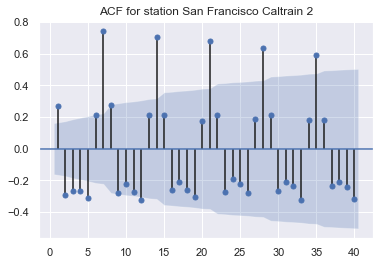

In [45]:
sgt.plot_acf(samplestat_train.dly_stat_trip_rt,lags=40,zero=False,color='b')
plt.title('ACF for station {}'.format(stn))
plt.show()

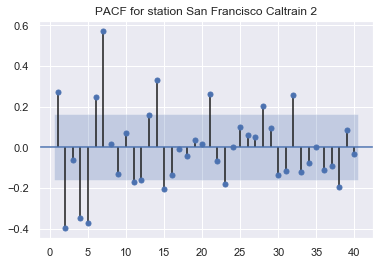

In [46]:
sgt.plot_pacf(samplestat_train.dly_stat_trip_rt,lags=40,zero=False,method='ols',color='b')
plt.title('PACF for station {}'.format(stn))
plt.show()

<b>The Sarima model requires certain parameters for the AR and MA components of the time series. As seen above,these parameters can be determined from the ACF/PACF plots. However, it is not easy and accurate to predict the p,d,q values based on visualizing the data. Hence we use a few statistical libraries to help us build our model. </b>

<b>Method 1 - Holt-Winters Method</b>


Holt-Winters is a model of time series behavior. Forecasting always requires a model, and Holt-Winters is a way to model three aspects of the time series: a
typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality). Holt-Winters uses exponential smoothing to encode lots of
values from the past and use them to predict “typical” values for the present and future.



<b>We fit this model on our training data and predict the test data.</b>

In [47]:
ESmodel=ExponentialSmoothing(samplestat_train['dly_stat_trip_rt'],trend='mul',seasonal='mul',seasonal_periods=7).fit()
ESpred=ESmodel.forecast(37)
ESpred

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning:

invalid value encountered in less_equal

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal



2014-07-26    1.992683
2014-07-27    1.983554
2014-07-28    4.782826
2014-07-29    4.695433
2014-07-30    4.462455
2014-07-31    4.712396
2014-08-01    4.504064
2014-08-02    2.004419
2014-08-03    1.995235
2014-08-04    4.810994
2014-08-05    4.723086
2014-08-06    4.488736
2014-08-07    4.740149
2014-08-08    4.530590
2014-08-09    2.016224
2014-08-10    2.006986
2014-08-11    4.839328
2014-08-12    4.750902
2014-08-13    4.515172
2014-08-14    4.768066
2014-08-15    4.557272
2014-08-16    2.028098
2014-08-17    2.018806
2014-08-18    4.867829
2014-08-19    4.778882
2014-08-20    4.541764
2014-08-21    4.796147
2014-08-22    4.584112
2014-08-23    2.040042
2014-08-24    2.030696
2014-08-25    4.896497
2014-08-26    4.807027
2014-08-27    4.568512
2014-08-28    4.824393
2014-08-29    4.611110
2014-08-30    2.052057
2014-08-31    2.042655
Freq: D, dtype: float64

<b>We compare how accurate the predicted test results are compared to the actual test results</b>

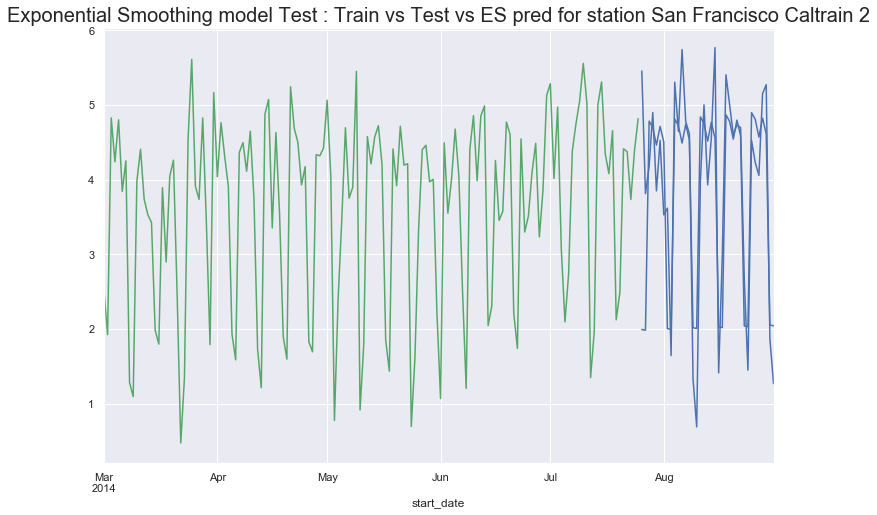

In [48]:
samplestat_train.dly_stat_trip_rt.plot(figsize=(12,6),color='g')
samplestat_test.dly_stat_trip_rt.plot(figsize=(12,6),color='b')
ESpred.plot(figsize=(12,8))
plt.title('Exponential Smoothing model Test : Train vs Test vs ES pred for station {}'.format(stn),size=20)
plt.show()

<b>Despite prediction error, evaluating the model we see that the error is acceptable when we look at the RMSE values as compared to the averagedaily station trip rate in the data</b>

In [49]:
print("Evaluating test predictions for ES model")
print('mean_absolute_error :'+str(mean_absolute_error(samplestat_test.dly_stat_trip_rt,ESpred)))
print('mean_squared_error :'+str(mean_squared_error(samplestat_test.dly_stat_trip_rt,ESpred)))
print('Root mean_squared_error :'+str(np.sqrt(mean_squared_error(samplestat_test.dly_stat_trip_rt,ESpred))))

Evaluating test predictions for ES model
mean_absolute_error :0.6517359365454848
mean_squared_error :0.8340223731952969
Root mean_squared_error :0.9132482538692844


<b>We now use the model to forecast the future data for the month of 2014, September</b>

In [50]:
ESpred_fcast=ExponentialSmoothing(samplestat['dly_stat_trip_rt'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
ESpred_forecast=ESpred_fcast.forecast(30)
ESpred_forecast

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning:

invalid value encountered in less_equal

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



2014-09-01    4.379423
2014-09-02    3.515399
2014-09-03    3.571413
2014-09-04    3.484114
2014-09-05    3.306571
2014-09-06    3.870746
2014-09-07    4.043699
2014-09-08    4.048287
2014-09-09    3.856680
2014-09-10    3.852542
2014-09-11    3.897354
2014-09-12    4.440682
2014-09-13    4.290560
2014-09-14    3.444068
2014-09-15    3.498945
2014-09-16    3.413417
2014-09-17    3.239477
2014-09-18    3.792205
2014-09-19    3.961648
2014-09-20    3.966143
2014-09-21    3.778424
2014-09-22    3.774370
2014-09-23    3.818273
2014-09-24    4.350576
2014-09-25    4.203500
2014-09-26    3.374184
2014-09-27    3.427948
2014-09-28    3.344156
2014-09-29    3.173745
2014-09-30    3.715257
Freq: D, dtype: float64

<b>Visualizing the 2014 september forecast by Holt-Winters Method, we see that there is scope for improvement to capture the data seasonality</b>

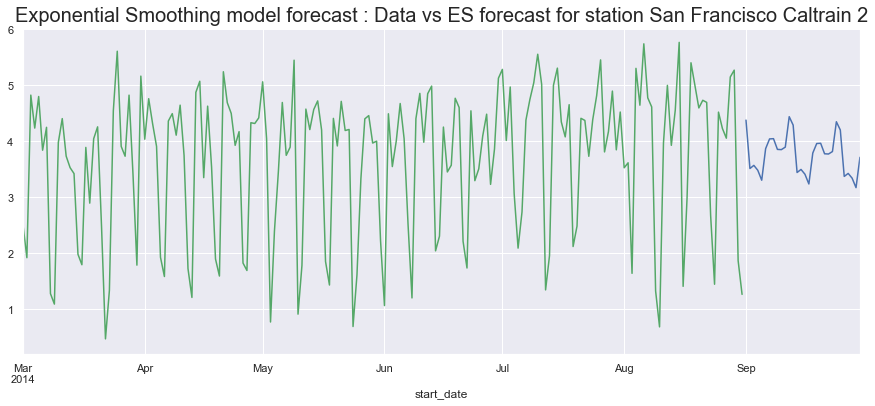

In [51]:
samplestat.dly_stat_trip_rt.plot(figsize=(12,6),color='g')
ESpred_forecast.plot(figsize=(15,6))
plt.title('Exponential Smoothing model forecast : Data vs ES forecast for station {}'.format(stn),size=20)
plt.show()

<b>Now, we move on to a more complex technique to capture the seasonality in the data by aplying the Seasonal ARIMA model as discussed.</b>


Auto Arima is powerful tool to help us determine the best fit model for our data. It returns the optimal set of parameters for our model

<b>Looking at the data for this sample zipcode , auto arima reccomends the SARIMAX(2, 0, 2)x(1, 1, 1, 12) model to us</b>

In [52]:
auto_arima(samplestat['dly_stat_trip_rt'],seasonal=True,m=12,error_action='ignore',D=1).summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimiza

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  184
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood                -238.448
Date:                              Sun, 16 Feb 2020   AIC                            492.896
Time:                                      03:42:27   BIC                            518.076
Sample:                                           0   HQIC                           503.112
                                              - 184                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0519      0.012      4.317      0.000       0.028       0.076
ar.L1          1.2499      0.002    501.381      0.000       1.245       1.255
ar.L2         -1.0000      0.001  -1660.330      0.000      -1.001      -0.999
ma.L1         -1.2569      1.280     -0.982      0.326      -3.765       1.251
ma.L2          0.9998      2.040      0.490      0.624      -2.999       4.998
ar.S.L12      -0.4747      0.082     -5.807      0.000      -0.635      -0.314
ma.S.L12      -0.9999    192.085     -0.005      0.996    -377.479     375.479
sigma2         0.6829    131.030      0.005      0.996    -256.131     257.497
===================================================================================
Ljung-Box (Q):                      194.21   Jarque-Bera (JB):                 5.39
Prob(Q):                              0.00   Prob(JB):                         0.07
Heteroskedasticity (H):               1.58   Skew:                             0.41
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<b>Aplying the recommended model to our training data for the sample station</b>

In [53]:
SARIMAXsampletrainmodel = SARIMAX(samplestat_train['dly_stat_trip_rt'],order=(2,0,2),seasonal_order=(1,1,1,12))
SARIMAXfittrain = SARIMAXsampletrainmodel.fit()

<b>Aplying the recommended model to our test data for the sample zip predictions</b>

In [54]:
#Obtain predicted values
startsar=len(samplestat_train)
endsar=len(samplestat_train)+len(samplestat_test)-1
SARIMAXpred = SARIMAXfittrain.predict(start=startsar, end=endsar, dynamic=False, typ='levels')

<b>Visualizing how our predcitions did as compared to the actual test data</b>

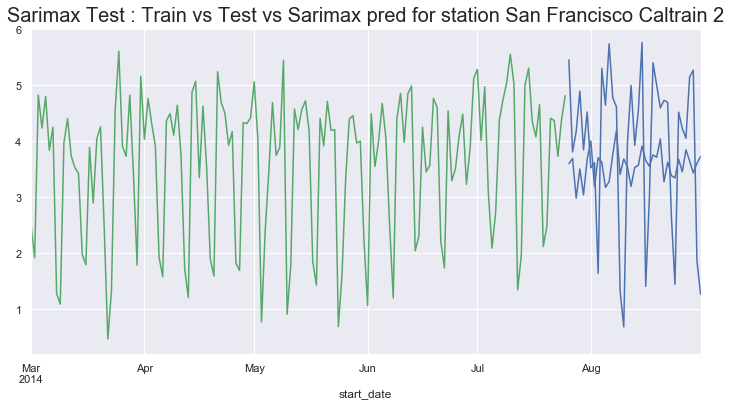

In [55]:
samplestat_train['dly_stat_trip_rt'].plot(figsize=(12,6),color='g')
samplestat_test['dly_stat_trip_rt'].plot(figsize=(12,6),color='b')
SARIMAXpred.plot(figsize=(12,6),title='pred')
plt.title('Sarimax Test : Train vs Test vs Sarimax pred for station {}'.format(stn),size=20)
plt.show()

<b>Aplying the recommended model to entire sample data to fit the model again</b>

In [56]:
SARIMAXsamplemodel = SARIMAX(samplestat['dly_stat_trip_rt'],order=(0,0,1),seasonal_order=(2,1,2,12))
SARIMAXfit = SARIMAXsamplemodel.fit()

<b>Aplying the recommended model to entire sample data to predict unseen future data</b>

In [57]:
#Obtain predicted values
startf2=len(samplestat)
endf2=len(samplestat)+24
SARIMAXfcast = SARIMAXfit.predict(start=startf2, end=endf2, dynamic=False, typ='levels')

<b>Visualizing the SARIMAX model's predction for 2014 September, shows the captured seasonality aspect unlike the Holt-Winters Method</b>

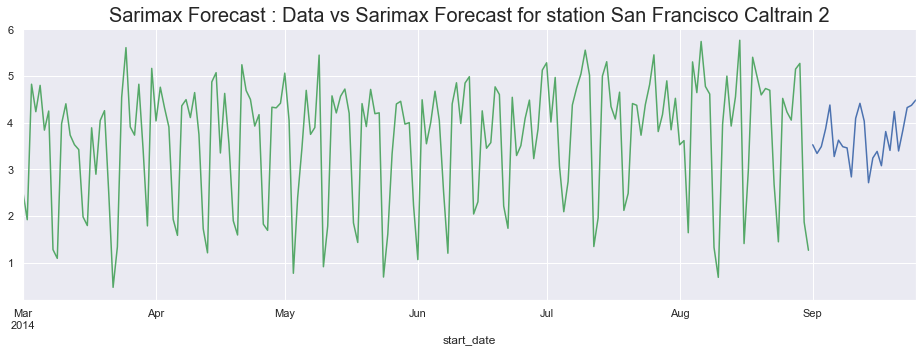

In [58]:
samplestat['dly_stat_trip_rt'].plot(figsize=(16,5),color='g')
SARIMAXfcast.plot(figsize=(16,5),title='pred')
plt.title('Sarimax Forecast : Data vs Sarimax Forecast for station {}'.format(stn),size=20)
plt.show()

<b>This function uses the approach defined above to use auto arima to tune the SARIMAX parameters and predict the Daily Station Trip Rate for each station in the bikeshare data for September 2014</b>

In [59]:
#Create a mapping of area for each station
area_map=pd.Series(df_bk_rt.area.values,index=df_bk_rt.strt_stat).to_dict()
df_area = pd.DataFrame()
df_area['strt_stat'] = area_map.keys()
df_area['area'] = area_map.values()

#Function to apply seasonal Arima for each station
def applysarimax(df,fperiod):
    z=auto_arima(df['dly_stat_trip_rt'],seasonal=True,m=12,error_action='ignore',D=1)
    p,d,q=z.order
    sp,sd,sq,per=z.seasonal_order
    sarmod=SARIMAX(df['dly_stat_trip_rt'],order=(p,d,q),seasonal_order=(sp,sd,sq,per))
    results = sarmod.fit()
    start=len(df)
    end=len(df) + fperiod
    sarpred = results.predict(start=start, end=end, dynamic=False, typ='levels')
    sarpred=sarpred.reset_index()
    sarpred.columns=['start_date','dly_stat_trip_rt']
    sarpreddf = pd.DataFrame(sarpred)
    return sarpreddf
    
def predict_stat_trip_rt(df,forecast_period):
    tempdf = pd.DataFrame()
    bayarea_stat = list(df['strt_stat'].unique())
    for i in bayarea_stat:
        tempzip=df[df['strt_stat']==i]
        tempzip=tempzip.set_index('start_date')
        predprices=applysarimax(tempzip,forecast_period)
        predprices['strt_stat']=i
        tempdf=tempdf.append(predprices,ignore_index=True)
    #for each zipcode add sizerank and neighbourhood information
    tempdf_m = pd.merge(tempdf, area_map[['strt_stat','area']], on='strt_stat', how="left")
    
    return tempdf_m1

In [ ]:
fcast_trip_rt=predict_stat_trip_rt(df_bk_rt,7)
fcast_trip_rt.shape

<b>The above code should give the forecast station trip rate based on which we can invest more for bikes in these area</b>